In [1]:
using LinearAlgebra
using Plots
using SparseArrays





using Distributions
using JLD

using Flux
using Random
using LaTeXStrings
using ProgressBars
using Zygote
stop_gradient(f) = f()
Zygote.@nograd stop_gradient

In [2]:
struct ROM_struct
    basis
    local_basis
    S
    S_inv
    f
    P
    A
end

function gen_ROM(snapshots,f;r=1,I=10,overlap = 1,localize = true)
    N = size(snapshots)[1]
    J = Int(N/I)
    if localize

        m = reshape( snapshots,(J,I,size(snapshots)[2]))
        snapshots = m
        for i in 1:overlap
            snapshots = [snapshots;circshift(m,(0,-i,0))]
        end

        snapshots = reshape(snapshots,(size(snapshots)[1],size(snapshots)[2]*size(snapshots)[3]))
        if overlap == 0
            local_basis = svd(snapshots).U[:,1:r]
        else
            #local_basis = svd(hat_funct(size(snapshots)[1],overlap = overlap) .* snapshots).U[:,1:r]
            local_basis = svd(hat_funct(size(snapshots)[1],overlap = overlap) .* snapshots).U[:,1:r]
        end


        offset = 0
        basis = zeros(N,(I)*r)
        total_modes = size(basis)[2]
        width = size(local_basis)[1]
        for i in 1:I
            basis[1:width,1:r] = local_basis
            basis = circshift(basis,(J,r))
        end
    else
        basis = svd(snapshots).U[:,1:I*r]
        local_basis = basis
        total_modes = size(basis)[2]

    end
    basis = sparsify_matrix(basis)
    S = basis' * basis
    S_inv = inv(Matrix(S))
    A = gen_operator(x,f,basis)
    _f_(a,x,t, S = S, A = A) =  S \ (A*a) #+ vcat([sum(a .* (quad_operator[i] * a),dims = 1) for i in 1:size(a)[1]]...))
    #_f_(a,x,t,S_inv = S_inv,basis = basis) = S_inv*(basis'*f(basis*a,x,t))
    return ROM_struct(basis,local_basis, S,S_inv,_f_,basis * S_inv * basis',A)
end
    

function sparsify_matrix(A,tolerance = 1e-10)
    B = spzeros(size(A))
    for i in 1:size(A)[1]
        for j in 1:size(A)[2]
            if abs(A[i,j]) >= tolerance
                B[i,j] += A[i,j]
            end
        end 
    end
    return B
end

function hat_funct(n;overlap = 0)
    eval = collect(1:n) .- 1/2
    return sin.(pi/(n)*eval).^(2)
end

function simulation(u0,x,dt,T,f;F = 0,save_every= 1)
    
    f_plus_forcing(u,x,t) = f(u,x,t) .+ F

    t= 0.
    u = u0

    ############
    us = Array{Float64}(undef, size(u0)[1], 0)
    dus = Array{Float64}(undef,  size(u0)[1],0)
    ts = Array{Float64}(undef,  1,0)
    ############
    save_counter = save_every + 1
    counter = 1
    round_t = t
    while round_t <= T
        du = RK4(u,x,t,dt,f_plus_forcing)
        if save_counter > save_every
            #############################################

            us = cat((us, u)...,dims = 2)

            dus = cat((dus, f(u,x,t))...,dims = 2) #-forcing

            if length(size(u0)) > 1
                ts= [ts t*ones(1,size(u0)[2])]
            else
                ts = [ts t]
            end
            #############################################
            save_counter = 1
            counter += 1

        end
        u = u .+ dt*du

        t += dt
        save_counter += 1
        round_t = stop_gradient() do
            round(t,digits =10)
        end
    end
    return us,dus,ts
end

function gen_operator(x,f,basis)
    input = zeros(size(basis)[2])
    dims = size(basis)[2]
    
    lin_operator = spzeros(dims,dims)
    
    mat = inv([[1,2];;[1,4]])
    
    for i in 1:dims
        input = 0*input
        input[i] += 1
        output1 = (basis' * f(basis*input,x,0))
        input[i] += 1
        output2 = (basis' * f(basis*input,x,0))
        for h in 1:dims
            if output1[h] != 0
                a,b = mat * [output1[h],output2[h]]
                lin_operator[h,i] = a
                #@assert b == 0
            end
        end
    end

                
    return lin_operator
end

function index_converter(i,I)
    index = mod(i,I)
    if index == 0
        index = I
    end
    return index
end


function interpolation_matrix(x1,x2)
    h1 = x1[2] - x1[1]
    h2 = x2[2] - x2[1]
    M = spzeros(size(x1)[1],size(x2)[1])
    for i in 1:size(x1)[1]
        index = (x1[i]+x2[1])/h2
        fl = floor(Int,index)
        ce = ceil(Int,index)
        if fl-ce == 0
            weight = 1
        else
            weight = index - fl
        end
        M[i,index_converter(fl,size(x2)[1])] = 1-weight
        M[i,index_converter(ce,size(x2)[1])] = weight
    end
    return M
end
                                                                    
                                                                        

interpolation_matrix (generic function with 1 method)

In [3]:
function gen_stencil(N,coeffs,positions)
    mat = spzeros((N,N))
    stencil_width = size(coeffs)[1]
    for i in 1:N
        for j in 1:stencil_width
            mat[i,index_converter(i+positions[j],N)] = coeffs[j]
        end
    end
    return mat
end



function RK4(u,x,t,dt,f)
    k1 = f(u,x,t)
    k2 = f(u.+dt*k1/2,x,t+dt/2)
    k3 = f(u.+dt*k2/2,x,t+dt/2)
    k4 = f(u .+ dt*k3,x,t+dt)
    return 1/6*(k1.+2*k2.+2*k3.+k4)
end



RK4 (generic function with 1 method)

# Simulation

In [4]:
N = 500
#r = 300



#overlap =true

omega = 2*pi

x = (collect(1:N).-1/2)/N .* omega

D1 = Matrix(gen_stencil(size(x)[1],[-1,0,1]./(2*(x[2]-x[1])),[-1,0,1]))
D2 = Matrix(gen_stencil(size(x)[1],[1,-2,1]./(x[2]-x[1])^2,[-1,0,1]))
D3 = Matrix(gen_stencil(size(x)[1],[-1,2,-2,1]./(2*(x[2]-x[1]))^3,[-2,-1,1,2]))
#f(u,x,t,v = 0.01) = -4.5/3 * (u .* D1*u + D1*u.^2) + D3*u
f(u,x,t,v = 0.0) = -D1*u + v*D2*u
#f(u,x,t,v = 0.01) = -1/3 * (u .* D1*u + D1*u.^2) + v*D2*u



#############################
dt = 0.01 # time-step size
T = 2# simulate until t=T
save_every = 1 # save reference data every 10 time-steps
samples = 1 # number of simulations


us = Array{Float64}(undef, size(x)[1],0) # Store solution vectors
ts = Array{Float64}(undef,  1,0) # Store time
Fs = Array{Float64}(undef, size(x)[1],0) # Store forcing



for sample in tqdm(1:samples) # Checking if sample is even to determine type of BCs
    
    # Simulate the flow
    #u0 = 0.5*(sin.(4*pi*x/omega)) #.*  (x .< 1/2*pi) 
    u0 = exp.(-50 .* (1/4*pi .- x) .^2)#.*  (x .< 1/2*pi) 
    u,du,t = simulation(u0,x,dt,T,  f  ,F = 0,save_every = save_every) # simulate
    
    # Save quantities
    us = [us ;; u]
    ts = [ts t]
end


0.0%┣                                                ┫ 0/1 [00:01<00:-1, -1s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:04<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:04<Inf:Inf, InfGs/it]


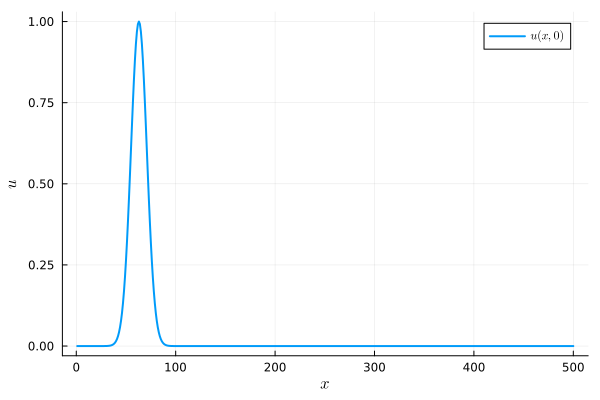

In [443]:
plot(us[:,1],linewidth = 2,label = L"u(x,0)")
xlabel!(L"x")
ylabel!(L"u")

# Data split

In [6]:
train_data = us[:,1:100]
val_data = us[:,100:200]

500×101 Matrix{Float64}:
 -1.58552e-15  -5.20875e-16   8.52079e-16  …   9.09417e-16   3.04501e-16
 -8.67081e-16  -1.74718e-15  -1.5886e-15       4.98539e-16   9.88122e-16
  1.61416e-15   4.93676e-16  -9.02139e-16     -8.89529e-16  -2.37745e-16
  9.4577e-16    1.77861e-15   1.55299e-15     -5.80107e-16  -1.03775e-15
 -1.53002e-15  -3.56023e-16   1.0044e-15       8.87568e-16   1.75643e-16
 -1.09592e-15  -1.77342e-15  -1.39593e-15  …   6.67101e-16   1.10897e-15
  1.3096e-15    5.95577e-17  -1.18978e-15     -9.03032e-16  -1.5132e-16
  1.3505e-15    1.73557e-15   1.06295e-15     -6.99875e-16  -1.10964e-15
 -9.4417e-16    4.59502e-16   1.60568e-15      8.33285e-16   8.19917e-17
 -1.77435e-15  -1.83888e-15  -8.43669e-16      7.42117e-16   1.02621e-15
  6.74942e-16  -8.36529e-16  -1.84316e-15  …  -6.31953e-16   1.83078e-16
  1.9355e-15    1.6794e-15    4.65744e-16     -9.77511e-16  -1.1406e-15
 -1.79787e-16   1.22003e-15   1.89023e-15      6.13035e-16  -2.76652e-16
  ⋮                         

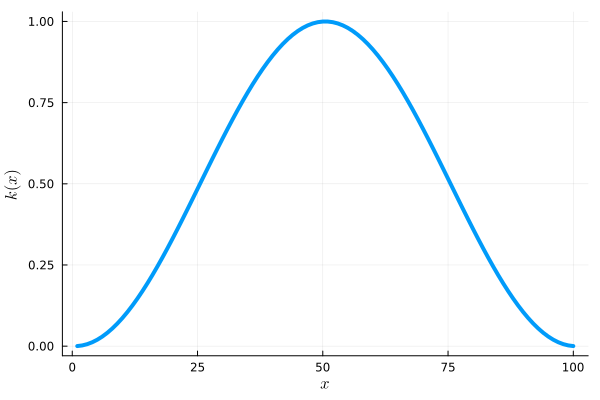

In [7]:
plot(hat_funct(100),linewidth = 4,label = false)
ylabel!(L"$k(x)$")
xlabel!(L"$x$")

# Sum of $k(x)$ functions

In [41]:
N = 300
I = 3
J = Int(N/I)

overlap = 1
r = 1



local_basis = hat_funct((overlap+1)*J,overlap = overlap)
offset = 0
basis = zeros(N,(I)*r)
total_modes = size(basis)[2]
width = size(local_basis)[1]
print(size(local_basis))
for i in 1:I
    basis[1:width,1:r] = local_basis
    basis = circshift(basis,(J,r))
end

(200,)

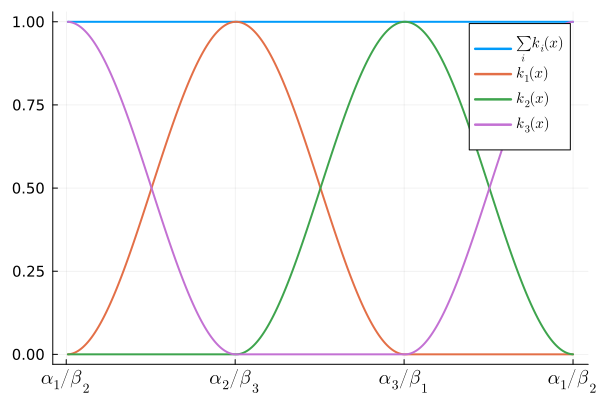

In [91]:
plot(sum(basis,dims = 2),linewidth = 2,label = L"\sum_i k_i(x)",xtickfont=font(13), 
    ytickfont=font(10), 
    guidefont=font(10), 
    legendfont=font(10))
plot!(basis,linewidth = 2,label = [L"k_1(x)" L"k_2(x)" L"k_3(x)"],xticks=([0,100,200,300],[L"\alpha_1/\beta_2",L"\alpha_2/\beta_3",L"\alpha_3/\beta_1",L"\alpha_1/\beta_2"]))

In [61]:
basis

300×3 Matrix{Float64}:
 6.16838e-5   0.0          0.999938
 0.000555063  0.0          0.999445
 0.00154133   0.0          0.998459
 0.00301952   0.0          0.99698
 0.00498817   0.0          0.995012
 0.00744534   0.0          0.992555
 0.0103886    0.0          0.989611
 0.013815     0.0          0.986185
 0.0177213    0.0          0.982279
 0.0221035    0.0          0.977897
 0.0269573    0.0          0.973043
 0.032278     0.0          0.967722
 0.0380602    0.0          0.96194
 ⋮                         
 0.0          0.032278     0.967722
 0.0          0.0269573    0.973043
 0.0          0.0221035    0.977897
 0.0          0.0177213    0.982279
 0.0          0.013815     0.986185
 0.0          0.0103886    0.989611
 0.0          0.00744534   0.992555
 0.0          0.00498817   0.995012
 0.0          0.00301952   0.99698
 0.0          0.00154133   0.998459
 0.0          0.000555063  0.999445
 0.0          6.16838e-5   0.999938

# Find best parameters for local POD

In [51]:
overlap = 1

#global_train_errs = []
local_train_errs = []
overlap_train_errs = []

#global_val_errs = []
local_val_errs = []
overlap_val_errs = []

Is = [5,10,20,25,50]

for I in Is
    rs = collect(1:floor(Int,100/I))
    #global_train_err = []
    local_train_err = []
    overlap_train_err = []

    #global_val_err = []
    local_val_err = []
    overlap_val_err = []
    for r in rs

        global_POD = gen_ROM(train_data,f,r = r,I = I,localize = false  )
        local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
        overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)

        #push!(global_train_err,mean((train_data - global_POD.P *train_data).^2 ))
        push!(local_train_err,mean((train_data - local_POD.P *train_data ).^2))
        push!(overlap_train_err,mean((train_data - overlap_POD.P *train_data ).^2))

        #push!(global_val_err,mean((val_data - global_POD.P *val_data).^2 ))
        push!(local_val_err,mean((val_data - local_POD.P *val_data ).^2))
        push!(overlap_val_err,mean((val_data - overlap_POD.P *val_data ).^2))
    end
    
    #push!(global_train_errs,global_train_err)
    push!(local_train_errs,local_train_err)
    push!(overlap_train_errs,overlap_train_err)

    #push!(global_val_errs,global_val_err)
    push!(local_val_errs,local_val_err)
    push!(overlap_val_errs,overlap_val_err)
    
    
end

┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149


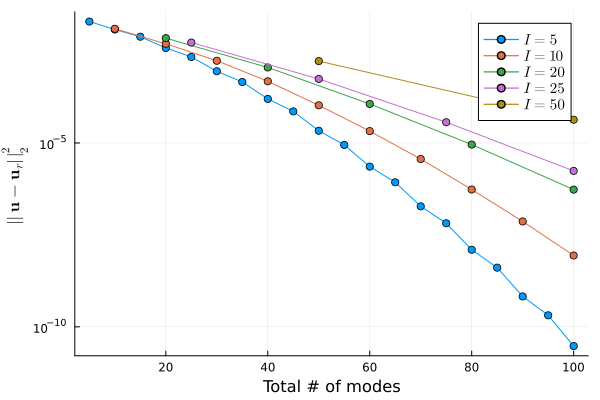

In [273]:
plot(yscale = :log, 
    legendfont=font(10))
for i in 1:size(Is)[1]
    I = Is[i]
    plot!(collect(1:size(local_train_errs[i])[1])*Is[i],local_train_errs[i],marker = "*",label = L"I = %$I") 
    
end
xlabel!("Total # of modes")
ylabel!(L"||\mathbf{u} - \mathbf{u}_r ||^2_2")
plot!()

┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149


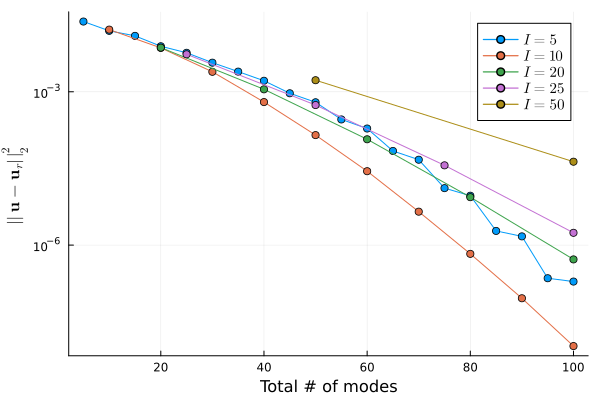

In [274]:
plot(yscale = :log, 
    legendfont=font(10))
for i in 1:size(Is)[1]
    I = Is[i]
    plot!(collect(1:size(local_val_errs[i])[1])*Is[i],local_val_errs[i],marker = "*",label = L"I = %$I") 
    
end
xlabel!("Total # of modes")
ylabel!(L"||\mathbf{u} - \mathbf{u}_r ||^2_2")
plot!()

┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149


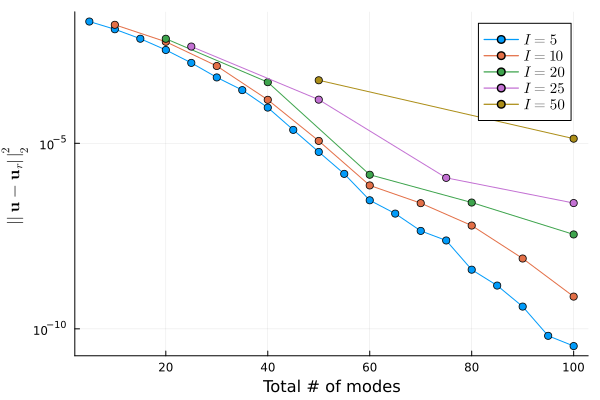

In [275]:
plot(yscale = :log, 
    legendfont=font(10))
for i in 1:size(Is)[1]
    I = Is[i]
    plot!(collect(1:size(overlap_train_errs[i])[1])*Is[i],overlap_train_errs[i],marker = "*",label = L"I = %$I") 
    
end
xlabel!("Total # of modes")
ylabel!(L"||\mathbf{u} - \mathbf{u}_r ||^2_2")
plot!()

┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149


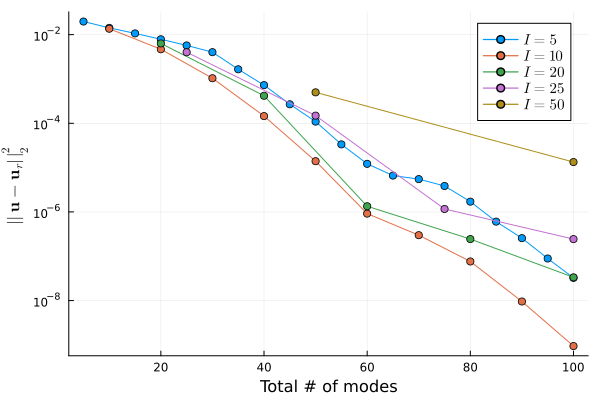

In [276]:
plot(yscale = :log, 
    legendfont=font(10))
for i in 1:size(Is)[1]
    I = Is[i]
    plot!(collect(1:size(overlap_val_errs[i])[1])*Is[i],overlap_val_errs[i],marker = "*",label = L"I = %$I") 
    
end
xlabel!("Total # of modes")
ylabel!(L"||\mathbf{u} - \mathbf{u}_r ||^2_2")
plot!()

# Compare ROMs

In [56]:
I = 10
overlap = 1

global_train_err = []
local_train_err = []
overlap_train_err = []
rs = collect(1:10)

global_val_err = []
local_val_err = []
overlap_val_err = []

for r in rs
    
    global_POD = gen_ROM(train_data,f,r = r,I = I,localize = false  )
    local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
    overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)

    push!(global_train_err,mean((train_data - global_POD.P *train_data).^2 ))
    push!(local_train_err,mean((train_data - local_POD.P *train_data ).^2))
    push!(overlap_train_err,mean((train_data - overlap_POD.P *train_data ).^2))
    
    push!(global_val_err,mean((val_data - global_POD.P *val_data).^2 ))
    push!(local_val_err,mean((val_data - local_POD.P *val_data ).^2))
    push!(overlap_val_err,mean((val_data - overlap_POD.P *val_data ).^2))
end

┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149


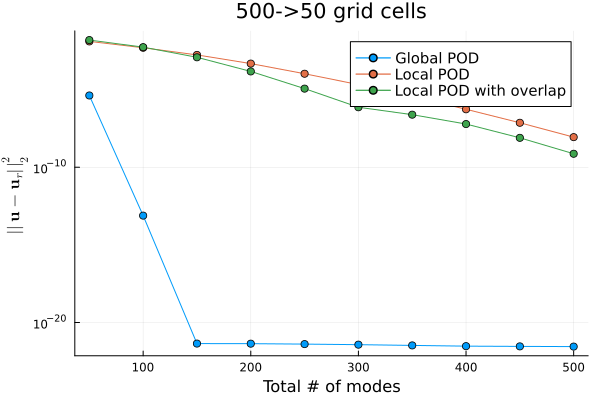

In [277]:
plot(rs *  I, global_train_err,marker = 'o',label = "Global POD",yscale = :log, 
    legendfont=font(10))
plot!(rs * I, local_train_err,marker = 'o',label = "Local POD")
plot!(rs * I, overlap_train_err,marker = 'o',label = "Local POD with overlap")
xlabel!("Total # of modes")
ylabel!(L"||\mathbf{u} - \mathbf{u}_r ||^2_2")
title!(string(size(train_data)[1]) * "->" * string(Int(I)) * " grid cells")

┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149


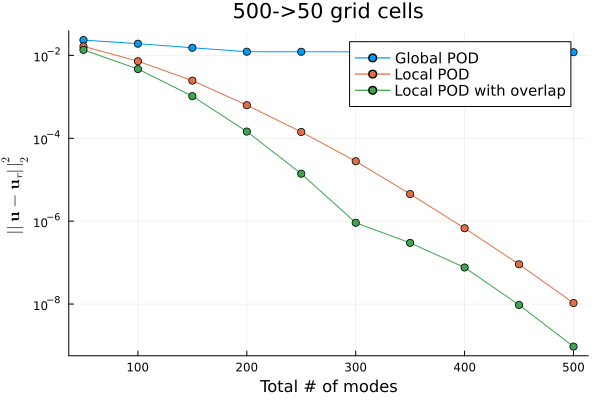

In [278]:
plot(rs *  I, global_val_err,marker = 'o',label = "Global POD",yscale = :log, 
    legendfont=font(10))
plot!(rs * I, local_val_err,marker = 'o',label = "Local POD")
plot!(rs * I, overlap_val_err,marker = 'o',label = "Local POD with overlap")
xlabel!("Total # of modes")
ylabel!(L"||\mathbf{u} - \mathbf{u}_r ||^2_2")
title!(string(size(train_data)[1])  * "->" * string(Int(I)) * " grid cells")

# Plot basis

In [419]:
I = 10
r = 5
overlap =1

global_POD = gen_ROM(train_data,f,r = r,I = I,localize = false  )
local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)



ROM_struct(sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  491, 492, 493, 494, 495, 496, 497, 498, 499, 500], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

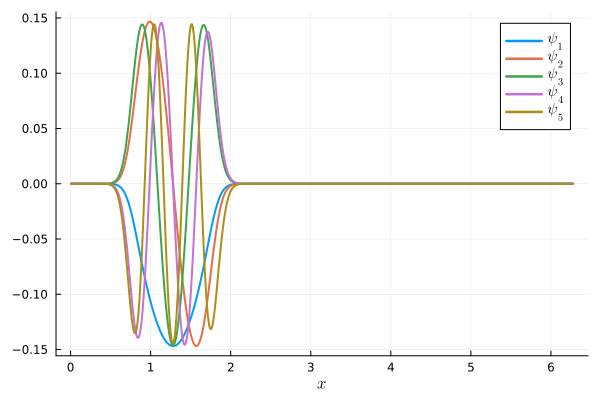

In [420]:
plot()
plot!(x,global_POD.basis[:,1:r],linewidth = 2,label = [L"\psi_1" L"\psi_2" L"\psi_3" L"\psi_4" L"\psi_5" L"\psi_6"], 
legendfont=font(10))
xlabel!(L"x")
plot!()

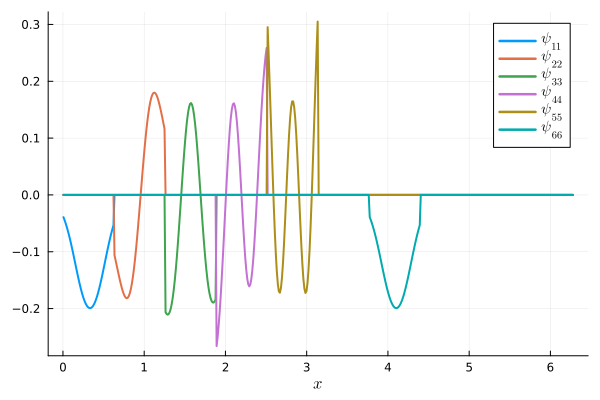

In [421]:
index = 3
plot()
for i in 1:6
    plot!(x,local_POD.basis[:,1+(i-1)*(r+1)],linewidth = 2,label = L"\psi_{%$i%$i}", 
    legendfont=font(10))
end
xlabel!(L"x")
plot!()



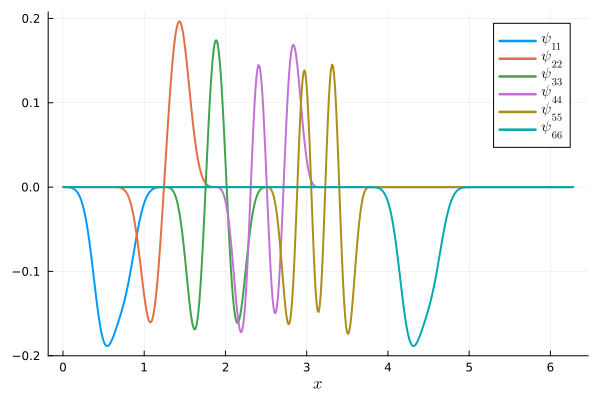

In [422]:
plot()
for i in 1:6
    plot!(x,overlap_POD.basis[:,1+(i-1)*(r+1)],linewidth = 2,label = L"\psi_{%$i%$i}", 
    legendfont=font(10))
end
xlabel!(L"x")
plot!()

# Single solution \& energy conservation

In [423]:
#############################
dt = 0.01 # time-step size
T = 5  #simulate until t=T
save_every = 1 # save reference data every 10 time-steps
#samples = 1 # number of simulations


t = 0
results = []
energy_error = []

ROMs = [global_POD,local_POD,overlap_POD]

u0 = exp.(-50 .* (1/2*pi .- x) .^2)
for i in ROMs
    
    
    a0 = i.S_inv * i.basis'*u0
    @time begin
    a,da,t = simulation(a0,zeros(size(i.S)[1]),dt,T,  i.f  ,F = 0,save_every = save_every) # simulate
    end

    # Save quantities
    u_r = i.basis * a
    push!(energy_error,((x[2]-x[1])* sum(u_r .* (i.basis * i.f(a,x,0)),dims = 1)))
    push!(results,u_r)
    
end

@time begin
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every) # simulate
push!(results,ref_u)
push!(energy_error, ((x[2]-x[1])* sum(ref_u .* f(ref_u,x,0),dims = 1)))
end
0

  0.340558 seconds (190.29 k allocations: 563.078 MiB, 11.50% gc time)
  0.113186 seconds (187.49 k allocations: 176.025 MiB, 11.05% gc time)
  0.160338 seconds (190.04 k allocations: 268.755 MiB, 12.47% gc time)
  1.253583 seconds (71.79 k allocations: 5.679 GiB, 24.48% gc time)


0

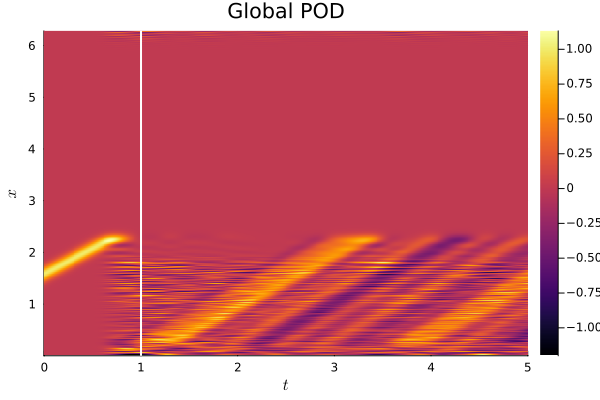

In [424]:
heatmap(t'[1:end],x,results[1])
vline!([1],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("Global POD")

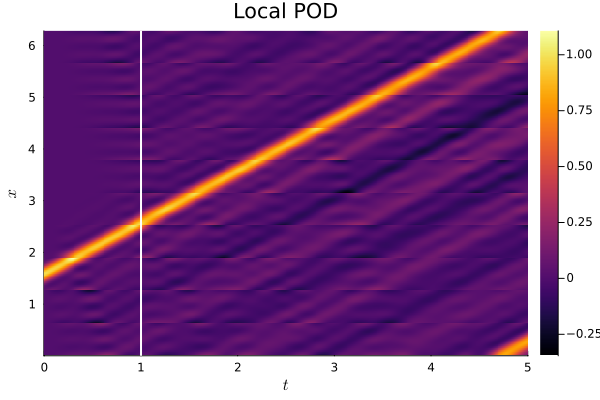

In [425]:
heatmap(t'[1:end],x,results[2])
vline!([1],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("Local POD")

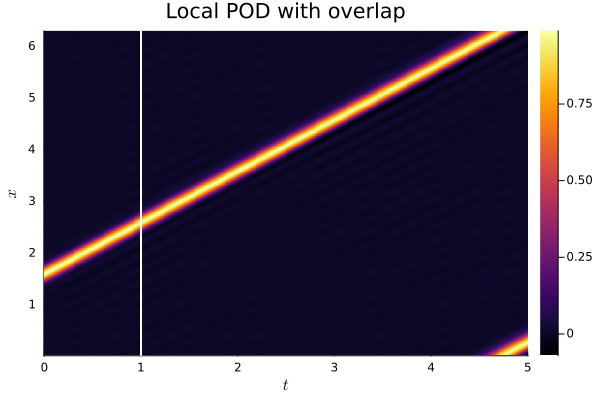

In [426]:
heatmap(t'[1:end],x,results[3])
vline!([1],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("Local POD with overlap")

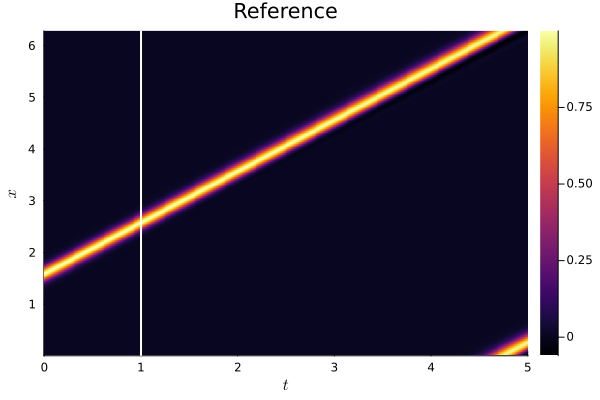

In [430]:
heatmap(t'[1:end],x,results[4])
vline!([1],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("Reference")

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584


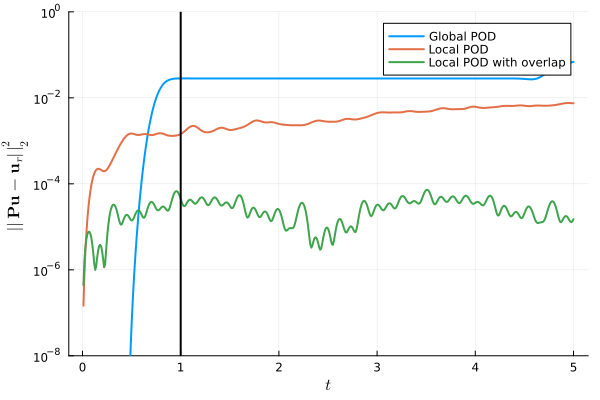

In [434]:
plot(ylimits = (1e-8,1.))
labels = ["Global POD","Local POD","Local POD with overlap"]
for i in 1:size(ROMs)[1]
    plot!(t'[2:end],mean((ROMs[i].P * results[4] - results[i]).^2,dims = 1)'[2:end],yscale = :log,label = labels[i],linewidth = 2)
end
vline!([1],linewidth = 2,color = :black,label =false)
plot!()
xlabel!(L"t")

ylabel!(L"||\mathbf{P}\mathbf{u} - \mathbf{u}_r ||^2_2")

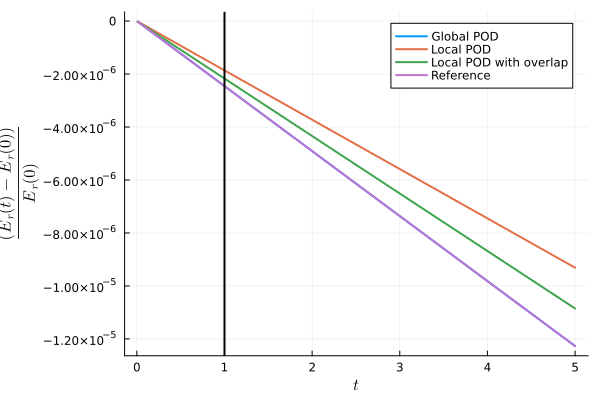

In [435]:
plot()
labels = ["Global POD","Local POD","Local POD with overlap","Reference"]
for i in 1:size(ROMs)[1]+1
    plot!(t'[2:end],(sum((results[i]).^2,dims = 1)'[2:end] .- sum((results[i]).^2,dims = 1)'[1])/(sum((results[i]).^2,dims = 1)'[1]),label = labels[i],linewidth = 2)
end
vline!([1],linewidth = 2,color = :black,label = false)
plot!()
xlabel!(L"t")
ylabel!(L"\frac{(E_r(t)-E_r(0))}{E_r(0)}")

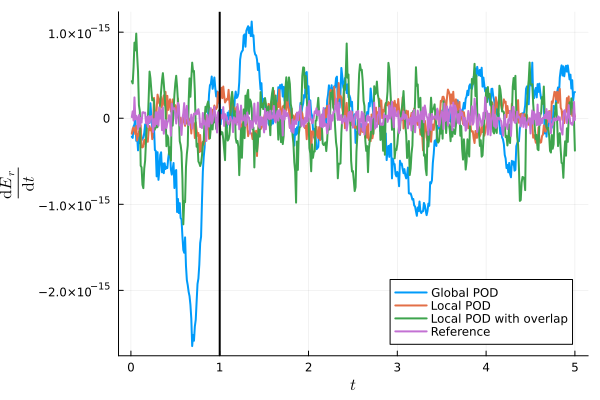

In [436]:
plot()
labels = ["Global POD","Local POD","Local POD with overlap","Reference"]
for i in 1:size(ROMs)[1]+1
    plot!(t'[2:end],energy_error[i][2:end],label = labels[i],linewidth = 2)
end
vline!([1],linewidth = 2,color = :black,label = false)
plot!()
xlabel!(L"t")
ylabel!(L"\frac{\mathrm{d}E_r}{\mathrm{d}t}")

# Plot convergence

## Run finite difference  

In [412]:
_Ns_ = 10*collect(1:49)

fd_error = []
fd_eval_times = []


u0 = exp.(-50 .* (1/2*pi .- x) .^2)
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every)


for _N_ in tqdm(_Ns_)

    #r = 300



    #overlap =true


    _x_ = (collect(1:_N_).-1/2)/_N_ .* omega

    _D1_ = Matrix(gen_stencil(size(_x_)[1],[-1,0,1]./(2*(_x_[2]-_x_[1])),[-1,0,1]))
    _D2_ = Matrix(gen_stencil(size(_x_)[1],[1,-2,1]./(_x_[2]-_x_[1])^2,[-1,0,1]))
    _D3_ = Matrix(gen_stencil(size(_x_)[1],[-1,2,-2,1]./(2*(_x_[2]-_x_[1]))^3,[-2,-1,1,2]))
    _f_(u,x,t,v = 0.01) = -4.5/3 * (u .* _D1_*u + _D1_*u.^2) + _D3_*u
    _f_(u,x,t,v = 0.0) = -_D1_*u + v*_D2_*u
    #_f_(u,x,t,v = 0.01) = -1/3 * (u .* _D1_*u + _D1_*u.^2) + v*_D2_*u

    M = interpolation_matrix(_x_,x)

    #############################
    dt = 0.01 # time-step size
    T = 5 # simulate until t=T
    

    u0 = exp.(-50 .* (1/2*pi .- _x_) .^2)

    ## First run for compilation
    u,du,t = simulation(u0,_x_,dt,2*dt,  _f_  ,F = 0,save_every = save_every) # simulate

    eval_time = @timed begin
    u,du,t = simulation(u0,_x_,dt,T,  _f_  ,F = 0,save_every = save_every) # simulate
    end
    push!(fd_error,N/(_N_)*mean(sum((M*ref_u - u).^2,dims = 1)))
    push!(fd_eval_times,eval_time[2])

end


0.0%┣                                               ┫ 0/49 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/49 [00:00<Inf:Inf, InfGs/it]
4.1%┣██                                              ┫ 2/49 [00:00<00:07, 7it/s]
6.1%┣███                                             ┫ 3/49 [00:00<00:05, 8it/s]
8.2%┣████                                            ┫ 4/49 [00:00<00:05, 9it/s]
10.2%┣████▉                                          ┫ 5/49 [00:00<00:05, 9it/s]
12.2%┣█████▊                                         ┫ 6/49 [00:01<00:05, 9it/s]
14.3%┣██████▊                                        ┫ 7/49 [00:01<00:05, 9it/s]
16.3%┣███████▊                                       ┫ 8/49 [00:01<00:05, 9it/s]
18.4%┣████████▋                                      ┫ 9/49 [00:01<00:05, 8it/s]
20.4%┣█████████▍                                    ┫ 10/49 [00:01<00:05, 8it/s]
22.4%┣██████████▎                                   ┫ 11/49 [00:01<00:05, 8it/s]
24.5%┣███████████▎          

## run POD

In [413]:
rs = collect(1:10)
I = 10
overlap =1

global_error = []
global_eval_times = []

local_error = []
local_eval_times = []


overlap_error = []
overlap_eval_times = []



u0 = exp.(-50 .* (1/2*pi .- x) .^2)
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every)
    #_us_ = Array{Float64}(undef, size(_x_)[1],0) # Store solution vectors


for r in tqdm(rs)
    
    global_POD = gen_ROM(train_data,f,r = r,I = I,localize = false,overlap = 0 )
    local_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = 0 )
    overlap_POD = gen_ROM(train_data,f,r = r,I = I,localize = true,overlap = overlap)


    #############################
    dt = 0.01 # time-step size
    T = 5  #simulate until t=T
    save_every = 1 # save reference data every 10 time-steps
    #samples = 1 # number of simulations


    t = 0
    results = []
    energy_error = []

    ROMs = [global_POD,local_POD,overlap_POD]
    error = [global_error,local_error,overlap_error]
    eval_times = [global_eval_times,local_eval_times,overlap_eval_times]

    u0 = exp.(-50 .* (1/2*pi .- x) .^2)
    for (i,j,k) in zip(ROMs,error,eval_times)


        a0 = i.S_inv * i.basis'*u0
        ## First run for compilation
        a,da,t = simulation(a0,zeros(size(i.S)[1]),dt,2*dt,  i.f  ,F = 0,save_every = save_every) # simulate
        eval_time = @timed begin
        a,da,t = simulation(a0,zeros(size(i.S)[1]),dt,T,  i.f  ,F = 0,save_every = save_every) # simulate
        end

        # Save quantities
        u_r = i.basis * a
        
        push!(j,mean(sum((i.P*ref_u - u_r).^2,dims = 1)))
        push!(k,eval_time[2])

    end

end

0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
10.0%┣████▏                                     ┫ 1/10 [00:00<Inf:Inf, InfGs/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:00<00:04, 2it/s]
30.0%┣██████████████                                 ┫ 3/10 [00:01<00:03, 2it/s]
40.0%┣██████████████████▉                            ┫ 4/10 [00:02<00:03, 2it/s]
50.0%┣███████████████████████▌                       ┫ 5/10 [00:02<00:03, 2it/s]
60.0%┣████████████████████████████▏                  ┫ 6/10 [00:03<00:03, 2it/s]
70.0%┣█████████████████████████████████              ┫ 7/10 [00:05<00:02, 1it/s]
80.0%┣█████████████████████████████████████▋         ┫ 8/10 [00:06<00:02, 1it/s]
90.0%┣██████████████████████████████████████████▎    ┫ 9/10 [00:08<00:01, 1s/it]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:10<00:00, 1s/it]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:10<00:00, 1s/it]


┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149


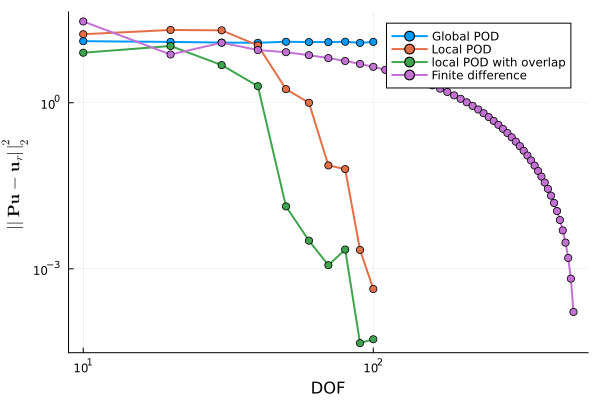

In [414]:
plot(10*collect(1:size(global_error)[1]),global_error,linewidth = 2,xscale = :log,marker = "*",yscale = :log,label= "Global POD")
plot!(10*collect(1:size(local_error)[1]),local_error,linewidth = 2,marker = "*",label = "Local POD")
plot!(10*collect(1:size(overlap_error)[1]),overlap_error,linewidth = 2,marker = "*",label = "local POD with overlap")
plot!(10*collect(1:size(fd_error)[1]),fd_error,linewidth = 2,marker = "*", label = "Finite difference")
xlabel!("DOF")
ylabel!(L"||\mathbf{P}\mathbf{u} - \mathbf{u}_r ||^2_2")

┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg *.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1149


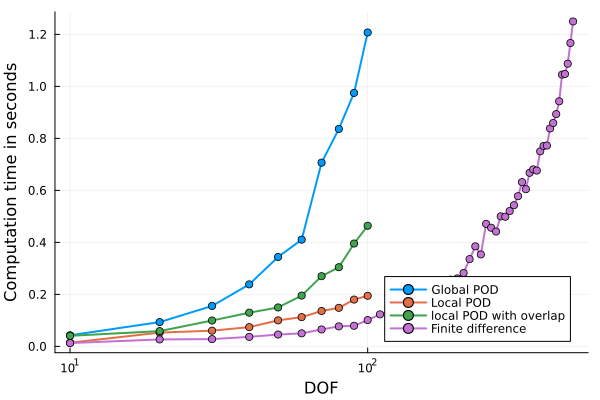

In [418]:
plot(10*collect(1:size(global_eval_times)[1]),global_eval_times,linewidth = 2,xscale = :log,marker = "*",label= "Global POD")
plot!(10*collect(1:size(local_eval_times)[1]),local_eval_times,linewidth = 2,marker = "*",label = "Local POD")
plot!(10*collect(1:size(overlap_eval_times)[1]),overlap_eval_times,linewidth = 2,marker = "*",label = "local POD with overlap")
plot!(10*collect(1:size(fd_eval_times)[1]),fd_eval_times,linewidth = 2,marker = "*", label = "Finite difference")
xlabel!("DOF")
ylabel!(L"||\mathbf{P}\mathbf{u} - \mathbf{u}_r ||^2_2")
xlabel!("DOF")
ylabel!("Computation time in seconds")

# Show experiment results

In [417]:
M[1:5,1:5]

5×5 SparseMatrixCSC{Float64, Int64} with 8 stored entries:
 1.0  2.22045e-16   ⋅            ⋅            ⋅ 
  ⋅   1.0          4.44089e-16   ⋅            ⋅ 
  ⋅    ⋅           1.0          4.44089e-16   ⋅ 
  ⋅    ⋅            ⋅           1.0           ⋅ 
  ⋅    ⋅            ⋅            ⋅           1.0

# Show energy conservation